In [1]:
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Input, Lambda, Concatenate
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
import keras.losses

import tensorflow as tf

import pandas as pd

import os
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import isolearn.io as isoio
import isolearn.keras as iso

from scipy.stats import pearsonr

from splirent.data.splirent_data_5ss_only_random_regions_cuts import load_data


Using TensorFlow backend.


In [2]:
#Load data generators

batch_size = 32

file_path = '../data/a5ss/processed_data/'
data_version = ''#'_neg_rate_1'
targeted_a5ss_file_path = None#'../../data/targeted_a5ss/processed_data/'

valid_set_size = 0.05#10000
test_set_size = 0.05#10000


splicing_gens = load_data(
    batch_size=batch_size,
    valid_set_size=valid_set_size,
    test_set_size=test_set_size,
    sequence_padding=5,
    file_path=file_path,
    data_version=data_version,
    use_shifter=False,
    targeted_a5ss_file_path=targeted_a5ss_file_path
)

truncated_n = int(len(splicing_gens['test']) * batch_size)


Training set size = 238183
Validation set size = 13232
Test set size = 13232


In [5]:
#Load model
save_dir_path = '../saved_models'

model_name = 'aparent_splirent_only_random_regions_cuts_drop_02_sgd'

model_path = os.path.join(save_dir_path, model_name + '.h5')

splicing_model = load_model(model_path)

<h2>Evaluate the Splicing CNN</h2>

Here we run our Splicing CNN on the Test set data generator (using Keras predict_generator).<br/>
We then compare our predictions of splice donor usage against the true RNA-Seq measurements.<br/>


413/413 [==============================] - 9s 21ms/step
Test set R^2 = 0.89, p = 0.0


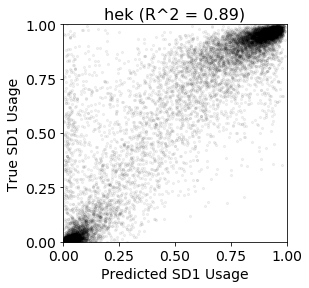

Test set R^2 = 0.89, p = 0.0


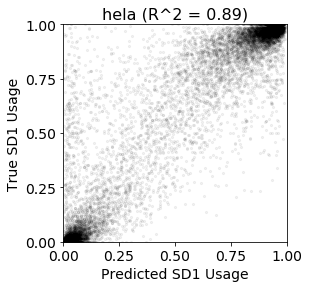

Test set R^2 = 0.88, p = 0.0


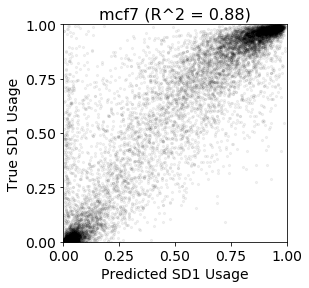

Test set R^2 = 0.89, p = 0.0


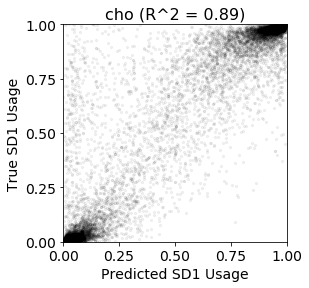

In [6]:
#Evaluate predictions on test set

save_figs = False

predictions = splicing_model.predict_generator(splicing_gens['test'], workers=4, use_multiprocessing=True, verbose=1)
pred_usage_hek, pred_usage_hela, pred_usage_mcf7, pred_usage_cho = [np.ravel(prediction[:, 0]) for prediction in predictions]

targets = list(zip(*[splicing_gens['test'][i][1] for i in range(len(splicing_gens['test']))]))
true_usage_hek, true_usage_hela, true_usage_mcf7, true_usage_cho = [np.ravel(np.concatenate(list(target))[:, 0]) for target in targets[:4]]

cell_lines = [
    ('hek', (pred_usage_hek, true_usage_hek)),
    ('hela', (pred_usage_hela, true_usage_hela)),
    ('mcf7', (pred_usage_mcf7, true_usage_mcf7)),
    ('cho', (pred_usage_cho, true_usage_cho))
]

for cell_name, [y_pred, y_true] in cell_lines :
    
    r_val, p_val = pearsonr(y_pred, y_true)
    print("Test set R^2 = " + str(round(r_val * r_val, 2)) + ", p = " + str(p_val))

    #Plot test set scatter
    f = plt.figure(figsize=(4, 4))

    plt.scatter(y_pred, y_true, color='black', s=5, alpha=0.05)
    
    plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
    plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
    plt.xlabel('Predicted SD1 Usage', fontsize=14)
    plt.ylabel('True SD1 Usage', fontsize=14)
    plt.title(str(cell_name) + " (R^2 = " + str(round(r_val * r_val, 2)) + ")", fontsize=16)
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    if save_figs :
        plt.savefig("splicing_cnn_test_scatter_" + str(model_name) + "_" + str(cell_name) + ".png", transparent=True, dpi=150)
        plt.savefig("splicing_cnn_test_scatter_" + str(model_name) + "_" + str(cell_name) + ".eps")
        plt.savefig("splicing_cnn_test_scatter_" + str(model_name) + "_" + str(cell_name) + ".svg")
    
    plt.show()


hek vs. hela
Delta PSI Test set R^2 = 0.09, p = 6.074611737969364e-280


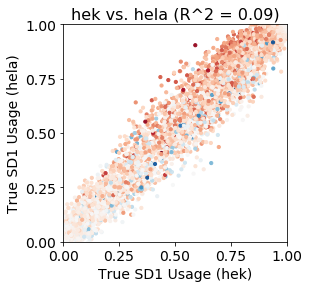

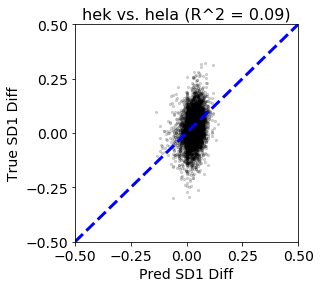

vmin = -0.13757563, vmax = 0.13881615


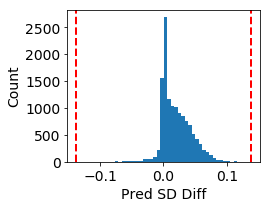

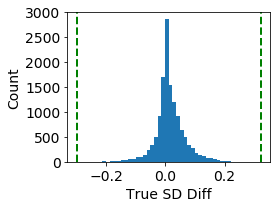

hek vs. mcf7
Delta PSI Test set R^2 = 0.35, p = 0.0


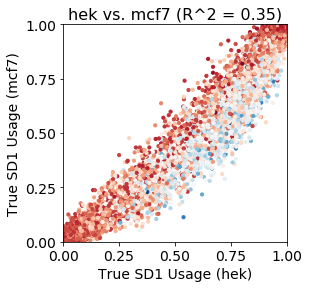

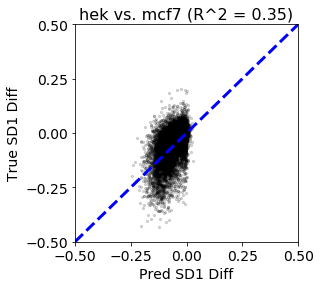

vmin = -0.24622953, vmax = 0.028714538


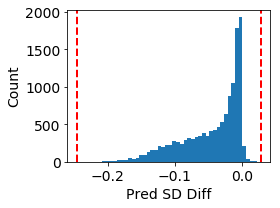

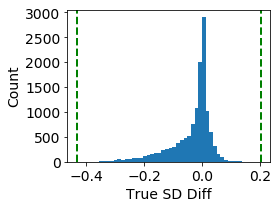

hek vs. cho
Delta PSI Test set R^2 = 0.24, p = 0.0


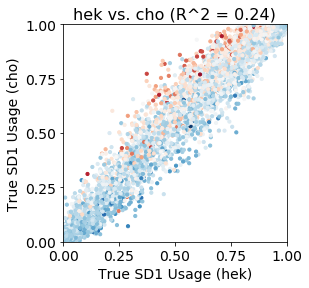

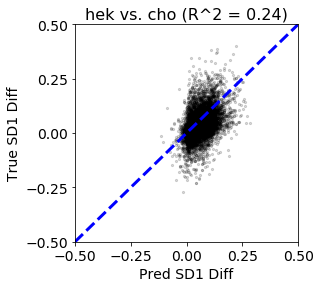

vmin = -0.11392522, vmax = 0.28493434


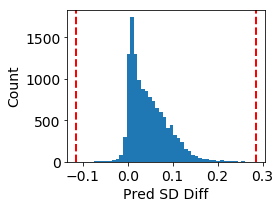

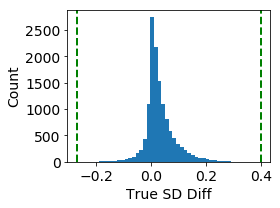

hela vs. hek
Delta PSI Test set R^2 = 0.09, p = 6.074611737969364e-280


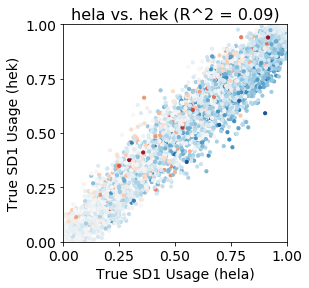

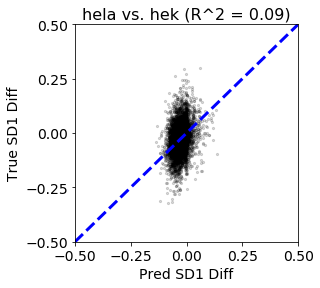

vmin = -0.13881615, vmax = 0.13757563


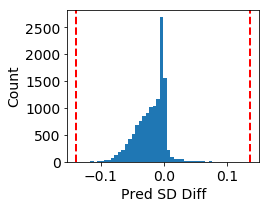

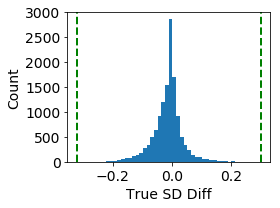

hela vs. mcf7
Delta PSI Test set R^2 = 0.37, p = 0.0


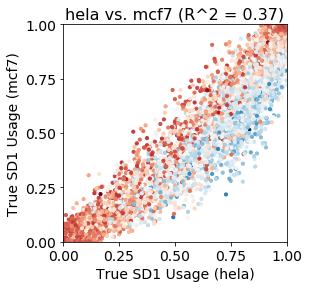

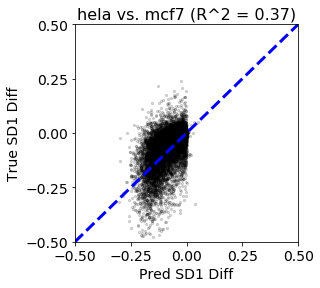

vmin = -0.30473378, vmax = 0.051660538


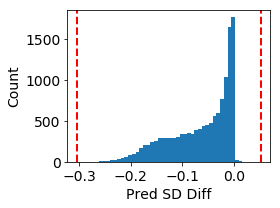

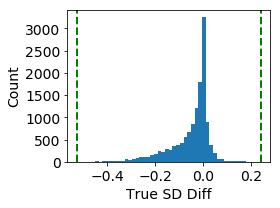

hela vs. cho
Delta PSI Test set R^2 = 0.09, p = 7.232138772203045e-274


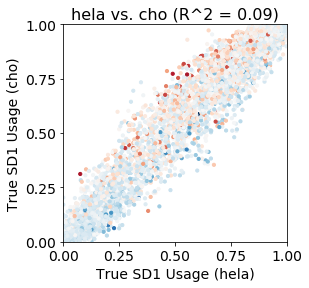

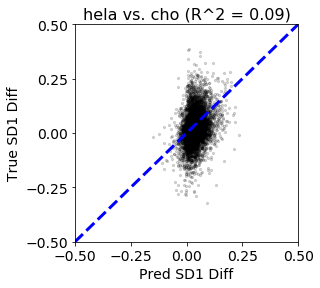

vmin = -0.15007281, vmax = 0.23279616


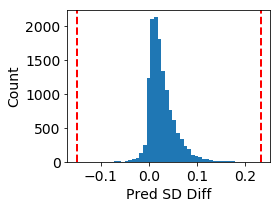

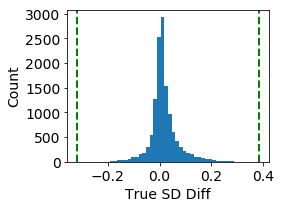

mcf7 vs. hek
Delta PSI Test set R^2 = 0.35, p = 0.0


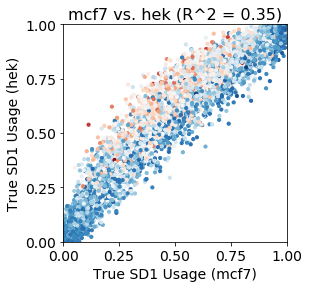

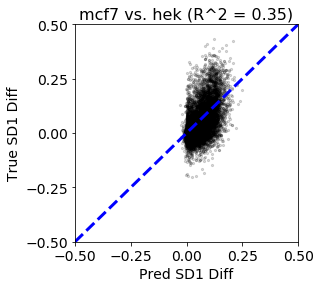

vmin = -0.028714538, vmax = 0.24622953


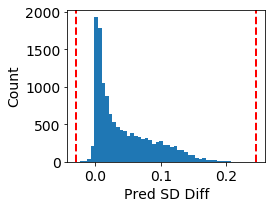

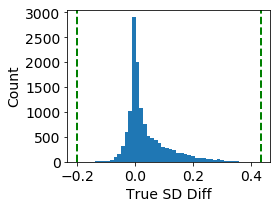

mcf7 vs. hela
Delta PSI Test set R^2 = 0.37, p = 0.0


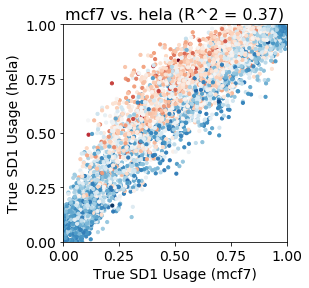

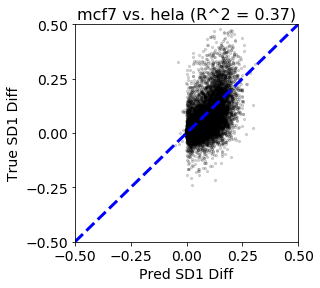

vmin = -0.051660538, vmax = 0.30473378


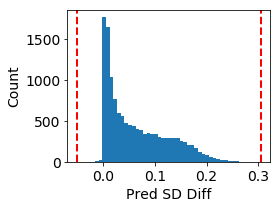

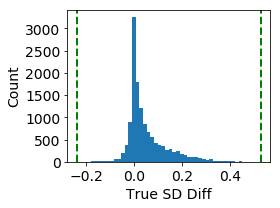

mcf7 vs. cho
Delta PSI Test set R^2 = 0.46, p = 0.0


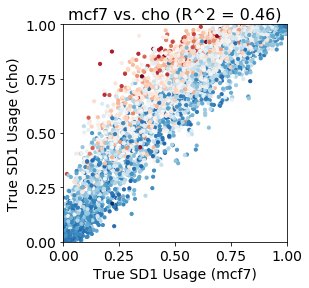

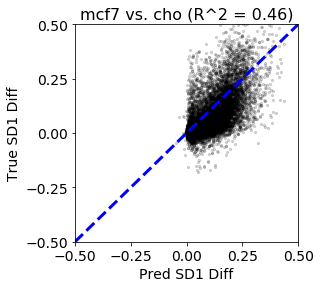

vmin = -0.048572153, vmax = 0.4371144


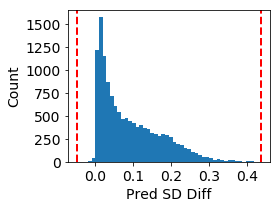

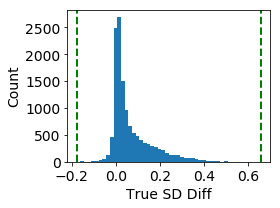

cho vs. hek
Delta PSI Test set R^2 = 0.24, p = 0.0


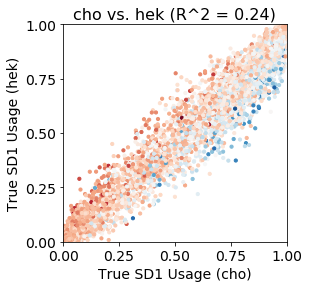

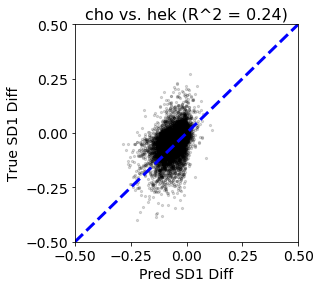

vmin = -0.28493434, vmax = 0.11392522


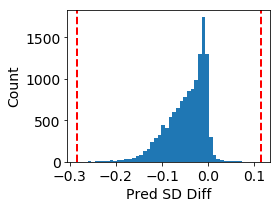

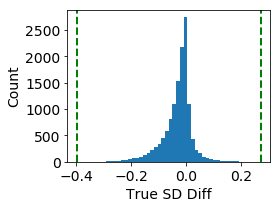

cho vs. hela
Delta PSI Test set R^2 = 0.09, p = 7.232138772203045e-274


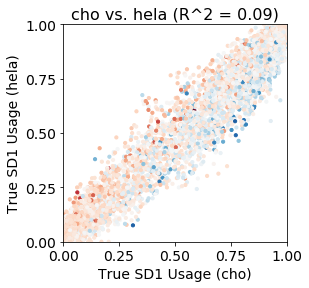

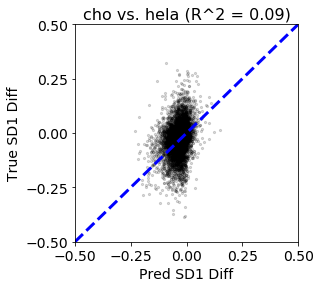

vmin = -0.23279616, vmax = 0.15007281


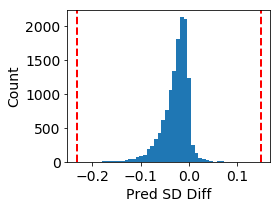

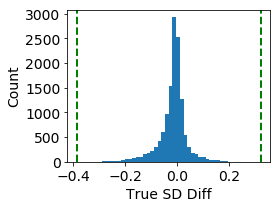

cho vs. mcf7
Delta PSI Test set R^2 = 0.46, p = 0.0


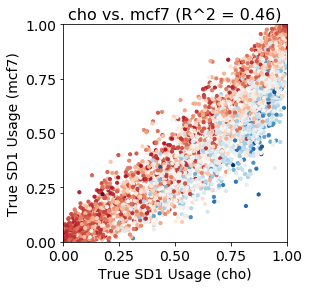

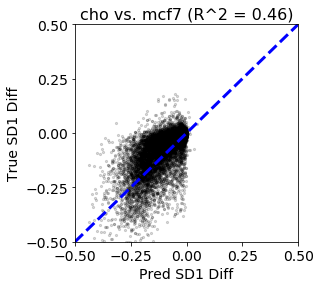

vmin = -0.4371144, vmax = 0.048572153


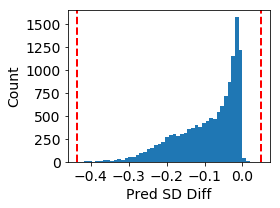

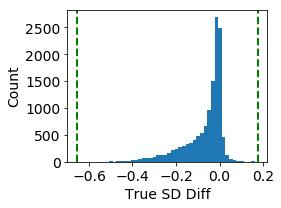

In [7]:
#Differential splicing test set evaluation

save_figs = False

for cell_name_1, [y_pred_1, y_true_1] in cell_lines :
    for cell_name_2, [y_pred_2, y_true_2] in cell_lines :
        
        if cell_name_1 != cell_name_2 :
            
            print(cell_name_1 + " vs. " + cell_name_2)

            #Plot test set scatter
            f = plt.figure(figsize=(4, 4))
            
            diff_true = y_true_2 - y_true_1
            diff_pred = y_pred_2 - y_pred_1
            
            r_val, p_val = pearsonr(diff_pred, diff_true)
            print("Delta PSI Test set R^2 = " + str(round(r_val * r_val, 2)) + ", p = " + str(p_val))
            
            valid_index = (y_true_1 > 0.0) & (y_true_1 < 1.0)
            valid_index = valid_index & ((y_true_2 > 0.0) & (y_true_2 < 1.0))
            
            plt.scatter(y_true_1, y_true_2, c=diff_pred, cmap='RdBu_r', vmin=np.min(diff_pred), vmax=np.max(diff_pred), s=10, alpha=1.0)

            plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
            plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
            plt.xlabel('True SD1 Usage (' + cell_name_1 + ')', fontsize=14)
            plt.ylabel('True SD1 Usage (' + cell_name_2 + ')', fontsize=14)
            plt.title(cell_name_1 + " vs. " + cell_name_2 + " (R^2 = " + str(round(r_val * r_val, 2)) + ")", fontsize=16)

            plt.xlim(0, 1)
            plt.ylim(0, 1)
            
            if save_figs :
                plt.savefig("splicing_cnn_diff_scatter_" + str(model_name) + "_" + str(cell_name_1) + "_vs_" + str(cell_name_2) + ".png", transparent=True, dpi=150)
                plt.savefig("splicing_cnn_diff_scatter_" + str(model_name) + "_" + str(cell_name_1) + "_vs_" + str(cell_name_2) + ".eps")
                plt.savefig("splicing_cnn_diff_scatter_" + str(model_name) + "_" + str(cell_name_1) + "_vs_" + str(cell_name_2) + ".svg")

            plt.show()
            
            f = plt.figure(figsize=(4, 4))

            plt.scatter(diff_pred, diff_true, color='black', s=5, alpha=0.15)
            plt.plot([-0.5, 0.5], [-0.5, 0.5], color='blue', linewidth=3, linestyle='--')

            plt.xticks([-0.5, -0.25, 0.0, 0.25, 0.5], fontsize=14)
            plt.yticks([-0.5, -0.25, 0.0, 0.25, 0.5], fontsize=14)
            plt.xlabel('Pred SD1 Diff', fontsize=14)
            plt.ylabel('True SD1 Diff', fontsize=14)
            plt.title(cell_name_1 + " vs. " + cell_name_2 + " (R^2 = " + str(round(r_val * r_val, 2)) + ")", fontsize=16)

            plt.xlim(-0.5, 0.5)
            plt.ylim(-0.5, 0.5)

            plt.show()

            print("vmin = " + str(np.min(diff_pred)) + ", vmax = " + str(np.max(diff_pred)))

            f = plt.figure(figsize=(4, 3))

            plt.hist(diff_pred, bins=50)

            plt.axvline(x=np.min(diff_pred), color='red', linewidth=2, linestyle='--')
            plt.axvline(x=np.max(diff_pred), color='red', linewidth=2, linestyle='--')

            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.xlabel('Pred SD Diff', fontsize=14)
            plt.ylabel('Count', fontsize=14)

            plt.tight_layout()
            plt.show()
            
            f = plt.figure(figsize=(4, 3))

            plt.hist(diff_true, bins=50)

            plt.axvline(x=np.min(diff_true), color='green', linewidth=2, linestyle='--')
            plt.axvline(x=np.max(diff_true), color='green', linewidth=2, linestyle='--')

            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.xlabel('True SD Diff', fontsize=14)
            plt.ylabel('Count', fontsize=14)

            plt.tight_layout()
            plt.show()



In [9]:
pred_df = splicing_gens['test'].sources['df'].iloc[splicing_gens['test'].data_ids[:truncated_n]].copy()

pred_df['sd1_true_hek'] = true_usage_hek
pred_df['sd1_true_hela'] = true_usage_hela
pred_df['sd1_true_mcf7'] = true_usage_mcf7
pred_df['sd1_true_cho'] = true_usage_cho

pred_df['sd1_pred_hek'] = pred_usage_hek
pred_df['sd1_pred_hela'] = pred_usage_hela
pred_df['sd1_pred_mcf7'] = pred_usage_mcf7
pred_df['sd1_pred_cho'] = pred_usage_cho

pred_df['total_count_hek'] = splicing_gens['test'].sources['hek_count'][splicing_gens['test'].data_ids[:truncated_n], :].sum(axis=-1)
pred_df['total_count_hela'] = splicing_gens['test'].sources['hela_count'][splicing_gens['test'].data_ids[:truncated_n], :].sum(axis=-1)
pred_df['total_count_mcf7'] = splicing_gens['test'].sources['mcf7_count'][splicing_gens['test'].data_ids[:truncated_n], :].sum(axis=-1)
pred_df['total_count_cho'] = splicing_gens['test'].sources['cho_count'][splicing_gens['test'].data_ids[:truncated_n], :].sum(axis=-1)


pred_df.to_csv('a5ss_test_pred_' + model_name + '.csv', index=False, sep='\t')
